First, we have to import necessary modules

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision  


Download Mnist dataset, and normalize to 0.3 and 0.3

In [37]:
batch_size = 64

# Preprocessing transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3,), (0.3,))  # Normalize the images to [-1, 1]
])

# Download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Define the MLP
Layers: two hidden layers, input and output layers
Activation functions: ReLU, Softmax, Dropout at 20%

In [38]:


# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)  # Input layer to hidden layer
        self.fc2 = nn.Linear(256, 128)   # Hidden layer to another hidden layer
        self.fc3 = nn.Linear(128, 10)   # Hidden layer to output layer
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here; CrossEntropyLoss applies softmax
        return x



# Initialize the model
model = MLP()


In [39]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


epochs = 10


Train the model for specified number of epochs, keeping track of training loss at each epoch

In [40]:
# Training loop with loss tracking and validation
train_losses = []


print("Training...")
for epoch in range(epochs):
    
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)



    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}")


Training...
Epoch [1/10], Train Loss: 0.2535
Epoch [2/10], Train Loss: 0.1145
Epoch [3/10], Train Loss: 0.0840
Epoch [4/10], Train Loss: 0.0684
Epoch [5/10], Train Loss: 0.0577
Epoch [6/10], Train Loss: 0.0498
Epoch [7/10], Train Loss: 0.0444
Epoch [8/10], Train Loss: 0.0403
Epoch [9/10], Train Loss: 0.0380
Epoch [10/10], Train Loss: 0.0354


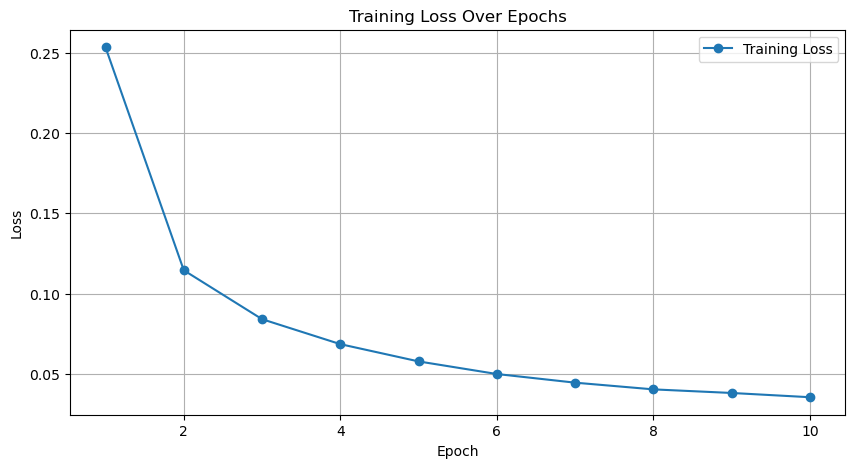

In [41]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

Test the model on the dataset, keeping track of error rates per digit and then graphing it

Overall Accuracy on the Test Set: 97.37%


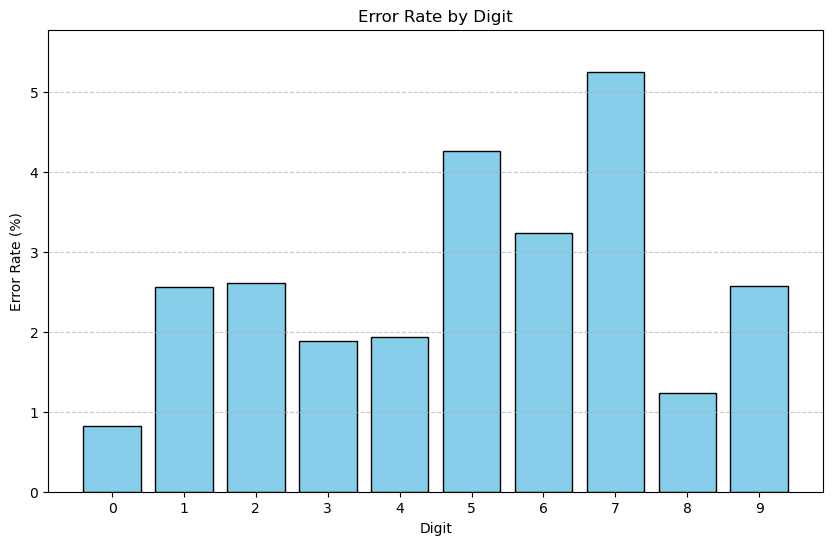

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize counters for correct predictions and totals per digit
digit_correct = np.zeros(10, dtype=int)
digit_totals = np.zeros(10, dtype=int)

# Evaluate the model for overall accuracy and per-digit accuracy
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update per-digit statistics
        for i in range(len(labels)):
            digit_totals[labels[i].item()] += 1
            if predicted[i].item() == labels[i].item():
                digit_correct[labels[i].item()] += 1

# Calculate overall accuracy
overall_accuracy = 100 * correct / total

# Calculate per-digit accuracies
digit_accuracies = 100 * digit_correct / digit_totals

# Print overall accuracy
print(f"Overall Accuracy on the Test Set: {overall_accuracy:.2f}%")


# Calculate error rates by digit
digit_errors = 100 - digit_accuracies

# Plot error rates
plt.figure(figsize=(10, 6))
plt.bar(range(10), digit_errors, color='skyblue', edgecolor='black')
plt.xlabel('Digit')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate by Digit')
plt.xticks(range(10))

# Set dynamic y-axis limits based on the data
max_error_rate = max(digit_errors)
plt.ylim(0, max_error_rate * 1.1)  # Add some padding above the highest bar

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Pick a subset of images and predict them, then display each image, label, and prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.6666666].


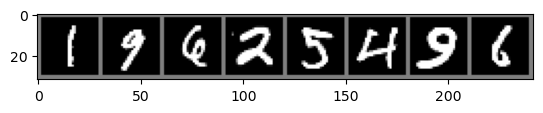

Labels:    1 9 6 2 5 4 9 6
Predicted: 1 9 6 2 5 4 9 6


In [43]:
import random

# Helper function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Select random indices from the test dataset
random_indices = random.sample(range(len(test_loader.dataset)), 8)
random_images = torch.stack([test_loader.dataset[i][0] for i in random_indices])
random_labels = torch.tensor([test_loader.dataset[i][1] for i in random_indices])

# Make predictions
outputs = model(random_images)
_, predicted = torch.max(outputs, 1)

# Show the selected random images with predictions
imshow(torchvision.utils.make_grid(random_images, nrow=8))
print("Labels:   ", " ".join(f"{random_labels[j].item()}" for j in range(8)))
print("Predicted:", " ".join(f"{predicted[j].item()}" for j in range(8)))



Load in the class digits, and try to predict them without first being trained on them

In [44]:
import projectdataloader as pdl

# Load custom data
custom_images, custom_labels = pdl.ProjectDataLoader()

# Convert labels from string to integer (since the labels are digits as strings like '3', '7', etc.)
custom_labels = [int(label) for label in custom_labels]  # Convert each label to an integer

# Convert the list of images into a single tensor (batch_size, 1, 28, 28)
custom_images = torch.stack([torch.tensor(image, dtype=torch.float32).unsqueeze(0) for image in custom_images])  # Add channel dimension

# Convert labels to a tensor of integers
custom_labels = torch.tensor([int(label) for label in custom_labels], dtype=torch.long)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(custom_images)
    _, predicted = torch.max(outputs, 1)

# Calculate overall accuracy
correct = (predicted == custom_labels).sum().item()
total = custom_labels.size(0)
accuracy = 100 * correct / total

# Display overall accuracy
print(f"Overall Accuracy: {accuracy:.2f}%")




Overall Accuracy: 46.13%


Display a subset of incorrectly guessed images

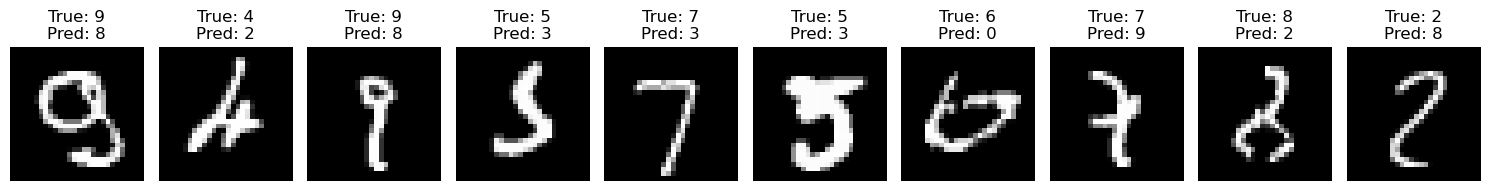

In [45]:
# Create a list to store misclassified images, true labels, and predicted labels
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

# Collect misclassified examples
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append(images[i].numpy())
                misclassified_true_labels.append(labels[i].item())
                misclassified_predicted_labels.append(predicted[i].item())

# Visualize misclassified images
num_images_to_show = min(len(misclassified_images), 10)  # Set a limit on the number of images to display
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

for idx in range(num_images_to_show):
    image = misclassified_images[idx]
    true_label = misclassified_true_labels[idx]
    predicted_label = misclassified_predicted_labels[idx]
    
    # Reshape image if needed (e.g., if it's grayscale or needs to squeeze the channel dimension)
    if image.shape[0] == 1:  # Grayscale image with shape (1, height, width)
        image = image.squeeze(0)
    
    # Display the image
    ax = axes[idx]
    ax.imshow(image, cmap="gray")  # Use cmap="gray" for grayscale images
    ax.axis("off")
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()

Calculate and graph the error rate per digit

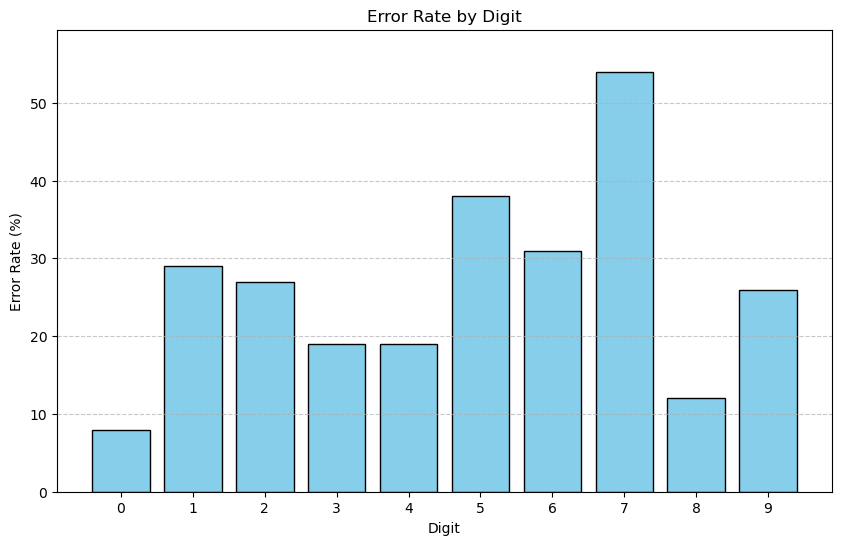

In [46]:
# Initialize counters for errors and totals per digit (0-9)
digit_errors = [0] * 10
digit_totals = [0] * 10

# Collect true labels and predictions across the entire test set
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, batch_predicted = torch.max(outputs, 1)
        
        # Extend true and predicted label lists
        true_labels.extend(labels.numpy())
        predicted_labels.extend(batch_predicted.numpy())

# Ensure true_labels and predicted_labels are the same length
assert len(true_labels) == len(predicted_labels), "Mismatch between true labels and predictions."

# Calculate errors and totals per digit
for i in range(len(true_labels)):
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]

    # Increment the total count for the digit
    digit_totals[true_label] += 1

    # Increment the error count if prediction is wrong
    if true_label != predicted_label:
        digit_errors[true_label] += 1

# Calculate the error rates per digit (percentage)
digit_error_rates = [100 * digit_errors[i] / digit_totals[i] if digit_totals[i] > 0 else 0 for i in range(10)]

# Plot error rates
plt.figure(figsize=(10, 6))
plt.bar(range(10), digit_errors, color='skyblue', edgecolor='black')
plt.xlabel('Digit')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate by Digit')
plt.xticks(range(10))

# Set dynamic y-axis limits based on the data
max_error_rate = max(digit_errors)
plt.ylim(0, max_error_rate * 1.1)  # Add some padding above the highest bar

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Now, train on a subset of the class data

In [47]:

from torch.utils.data import DataLoader, TensorDataset, random_split

# Split data into training and testing sets
dataset = TensorDataset(custom_images, custom_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Fine-tune the model on the new data
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Loss computation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Track metrics
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch 1/10, Loss: 1.4811, Accuracy: 55.44%
Epoch 2/10, Loss: 0.9517, Accuracy: 68.65%
Epoch 3/10, Loss: 0.8368, Accuracy: 72.08%
Epoch 4/10, Loss: 0.7895, Accuracy: 73.08%
Epoch 5/10, Loss: 0.6065, Accuracy: 80.24%
Epoch 6/10, Loss: 0.5054, Accuracy: 83.37%
Epoch 7/10, Loss: 0.4618, Accuracy: 86.09%
Epoch 8/10, Loss: 0.4211, Accuracy: 86.49%
Epoch 9/10, Loss: 0.3651, Accuracy: 87.90%
Epoch 10/10, Loss: 0.3748, Accuracy: 88.21%


Now that it has been trained on the class data, test it on a subset of the data to see if it improved

Overall Accuracy: 70.97%


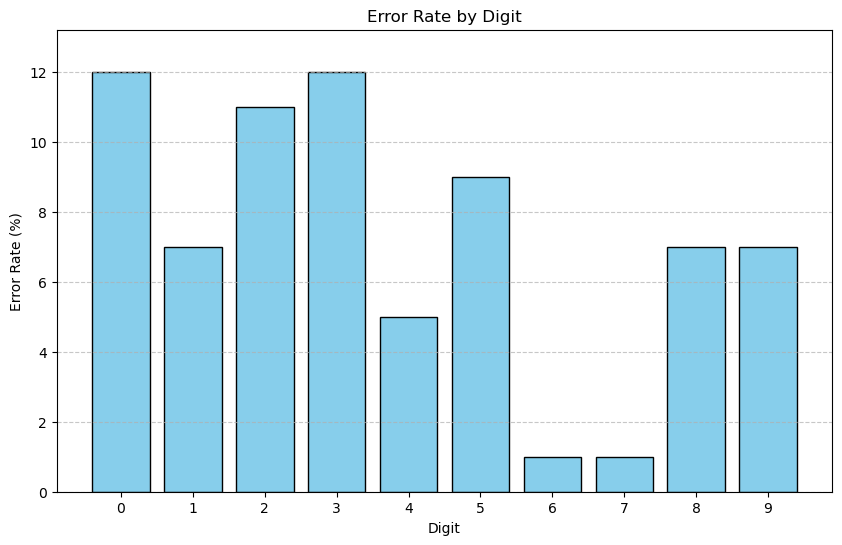

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

# Initialize a list to count errors for each digit (0 to 9)
digit_errors = [0] * 10
digit_totals = [0] * 10

# Evaluate the model on the test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
model.eval()  # Set model to evaluation mode

# Store predictions and true labels
predicted_labels = []
true_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Update counts for digit-wise errors and totals
        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()

            digit_totals[true_label] += 1
            if true_label != predicted_label:
                digit_errors[true_label] += 1

        # Store predictions and true labels for accuracy calculation
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())

# Calculate overall accuracy
accuracy = 100 * correct / total
print(f"Overall Accuracy: {accuracy:.2f}%")

# Calculate error rates per digit (percentage of errors for each digit)
digit_error_rates = [100 * digit_errors[i] / digit_totals[i] if digit_totals[i] > 0 else 0 for i in range(10)]

# Plot error rates
plt.figure(figsize=(10, 6))
plt.bar(range(10), digit_errors, color='skyblue', edgecolor='black')
plt.xlabel('Digit')
plt.ylabel('Error Rate (%)')
plt.title('Error Rate by Digit')
plt.xticks(range(10))

# Set dynamic y-axis limits based on the data
max_error_rate = max(digit_errors)
plt.ylim(0, max_error_rate * 1.1)  # Add some padding above the highest bar

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



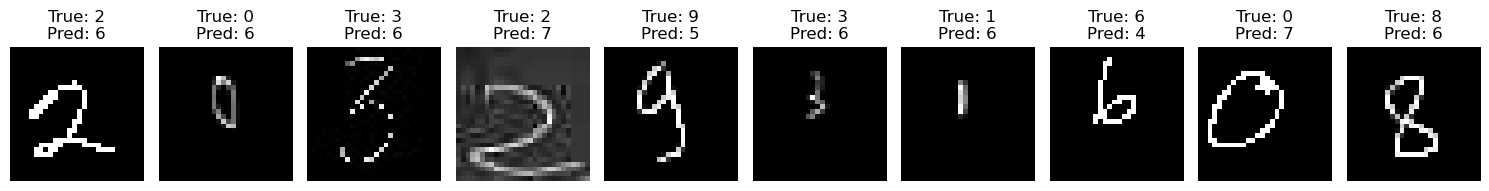

In [49]:


# Create a list to store misclassified images, true labels, and predicted labels
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

# Collect misclassified examples
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append(images[i].numpy())
                misclassified_true_labels.append(labels[i].item())
                misclassified_predicted_labels.append(predicted[i].item())

# Visualize misclassified images
num_images_to_show = min(len(misclassified_images), 10)  # Set a limit on the number of images to display
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

for idx in range(num_images_to_show):
    image = misclassified_images[idx]
    true_label = misclassified_true_labels[idx]
    predicted_label = misclassified_predicted_labels[idx]
    
    # Reshape image if needed (e.g., if it's grayscale or needs to squeeze the channel dimension)
    if image.shape[0] == 1:  # Grayscale image with shape (1, height, width)
        image = image.squeeze(0)
    
    # Display the image
    ax = axes[idx]
    ax.imshow(image, cmap="gray")  # Use cmap="gray" for grayscale images
    ax.axis("off")
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()
